In [33]:
# Copyright (c) Facebook, Inc. and its affiliates.
# 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
# 
#     http://www.apache.org/licenses/LICENSE-2.0
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
import os
import sys
import glob
import argparse
import cv2
import random
import colorsys
import requests
import pandas as pd
from io import BytesIO

In [34]:
import skimage.io
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np
from PIL import Image

In [35]:
import utils
import vision_transformer as vits

In [36]:
def apply_mask(image, mask, color, alpha=0.5):
    for c in range(3):
        image[:, :, c] = image[:, :, c] * (1 - alpha * mask) + alpha * mask * color[c] * 255
    return image

In [37]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

In [38]:
def display_instances(image, mask, fname="test", figsize=(5, 5), blur=False, contour=True, alpha=0.5):
    fig = plt.figure(figsize=figsize, frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax = plt.gca()

    N = 1
    mask = mask[None, :, :]
    # Generate random colors
    colors = random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    margin = 0
    ax.set_ylim(height + margin, -margin)
    ax.set_xlim(-margin, width + margin)
    ax.axis('off')
    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]
        _mask = mask[i]
        if blur:
            _mask = cv2.blur(_mask,(10,10))
        # Mask
        masked_image = apply_mask(masked_image, _mask, color, alpha)
        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        if contour:
            padded_mask = np.zeros((_mask.shape[0] + 2, _mask.shape[1] + 2))
            padded_mask[1:-1, 1:-1] = _mask
            contours = find_contours(padded_mask, 0.5)
            for verts in contours:
                # Subtract the padding and flip (y, x) to (x, y)
                verts = np.fliplr(verts) - 1
                p = Polygon(verts, facecolor="none", edgecolor=color)
                ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8), aspect='auto')
    fig.savefig(fname)
    print(f"{fname} saved.")
    return

In [39]:
class VisAttn:
    def __init__(self, 
                arch = 'vit_small', 
                patch_size = 16,
                pretrained_weights = None,
                checkpoint_key = 'teacher',
                image_size = (480, 480),
                output_dir = '.',
                threshold = None):
        self.arch = arch
        self.patch_size = patch_size
        self.pretrained_weights = pretrained_weights
        self.checkpoint_key = checkpoint_key
        self.image_size = image_size
        self.output_dir = output_dir
        self.threshold = threshold
        
    def prepareTransform(self):
        """
        """
        transform = pth_transforms.Compose([
        pth_transforms.Resize(self.image_size),
        pth_transforms.ToTensor(),
        pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
        self.transform = transform
        
        
    def prepareModel(self):
        """
        Given current parameters, prepare the model
        
        """
        # Prepare the model for investigation

        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.device = device
        # build model
        model = vits.__dict__[self.arch](patch_size=self.patch_size, num_classes=0)
        for p in model.parameters():
            p.requires_grad = False
        model.eval()
        model.to(device)
        if os.path.isfile(self.pretrained_weights):
            state_dict = torch.load(self.pretrained_weights, map_location="cpu")
            if self.checkpoint_key is not None and self.checkpoint_key in state_dict:
                print(f"Take key {self.checkpoint_key} in provided checkpoint dict")
                state_dict = state_dict[self.checkpoint_key]
            # remove `module.` prefix
            state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
            # remove `backbone.` prefix induced by multicrop wrapper
            state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}
            msg = model.load_state_dict(state_dict, strict=False)
            print('Pretrained weights found at {} and loaded with msg: {}'.format(self.pretrained_weights, msg))
        else:
            print("Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.")
            url = None
            if self.arch == "vit_small" and self.patch_size == 16:
                url = "dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth"
            elif self.arch == "vit_small" and self.patch_size == 8:
                url = "dino_deitsmall8_300ep_pretrain/dino_deitsmall8_300ep_pretrain.pth"  # model used for visualizations in our paper
            elif self.arch == "vit_base" and self.patch_size == 16:
                url = "dino_vitbase16_pretrain/dino_vitbase16_pretrain.pth"
            elif self.arch == "vit_base" and self.patch_size == 8:
                url = "dino_vitbase8_pretrain/dino_vitbase8_pretrain.pth"
            if url is not None:
                print("Since no pretrained weights have been provided, we load the reference pretrained DINO weights.")
                state_dict = torch.hub.load_state_dict_from_url(url="https://dl.fbaipublicfiles.com/dino/" + url)
                model.load_state_dict(state_dict, strict=True)
            else:
                print("There is no reference weights available for this model => We use random weights.")
        self.model = model

    def prepare(self):
        self.prepareModel()
        self.prepareTransform()
        
    def __readyImage(self, image_path):
        # open image
        if image_path is None:
            # user has not specified any image - we use our own image
            print("Please use the `--image_path` argument to indicate the path of the image you wish to visualize.")
            print("Since no image path have been provided, we take the first image in our paper.")
            response = requests.get("https://dl.fbaipublicfiles.com/dino/img.png")
            img = Image.open(BytesIO(response.content))
            img = img.convert('RGB')
        elif os.path.isfile(image_path):
            with open(image_path, 'rb') as f:
                img = Image.open(f)
                img = img.convert('RGB')
        else:
            print(f"Provided image path {image_path} is non valid.")
            sys.exit(1)

        img = self.transform(img)

        # make the image divisible by the patch size
        w, h = img.shape[1] - img.shape[1] % self.patch_size, img.shape[2] - img.shape[2] % self.patch_size
        img = img[:, :w, :h].unsqueeze(0)

        w_featmap = img.shape[-2] // self.patch_size
        h_featmap = img.shape[-1] // self.patch_size
        return img, w_featmap, h_featmap
    
    def getAttention(self, image_path):
        img, w_featmap, h_featmap = self.__readyImage(image_path)
        
        attentions = self.model.get_last_selfattention(img.to(self.device))

        nh = attentions.shape[1] # number of head

        # we keep only the output patch attention
        attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

        if self.threshold is not None:
            # we keep only a certain percentage of the mass
            val, idx = torch.sort(attentions)
            val /= torch.sum(val, dim=1, keepdim=True)
            cumval = torch.cumsum(val, dim=1)
            th_attn = cumval > (1 - self.threshold)
            idx2 = torch.argsort(idx)
            for head in range(nh):
                th_attn[head] = th_attn[head][idx2[head]]
            th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
            # interpolate
            th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=self.patch_size, mode="nearest")[0].cpu().numpy()

        attentions = attentions.reshape(nh, w_featmap, h_featmap)
        attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=self.patch_size, mode="nearest")[0].cpu().numpy()

        return attentions
    def getIntermediate(self, image_path, n = 1):
        img, w_featmap, h_featmap = self.__readyImage(image_path)
        output = self.model.get_intermediate_layers(img.to(self.device), n = n)
        output = np.array([q.cpu().numpy() for q in output])
        return output
    def getClsToken(self, image_path, n = 1):
        output = self.getIntermediate(image_path, n = n)
        cls = output[:,0,0]
        return cls
        
        
defaultPars = VisAttn()



In [40]:
# Set the parameters to be used here
myAttnVis = VisAttn(pretrained_weights = '/home/DXB05HN/model_pts/dino/checkpoint.pth')
myAttnVis.prepare()

# Get all the images from a given directory that might be inspected
fns = glob.glob("/home/DXB05HN/HDCLIPDataset200k/livingroombest/*.jpg")


Take key teacher in provided checkpoint dict
Pretrained weights found at /home/DXB05HN/model_pts/dino/checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])


In [41]:
# read in the dataframe of information
df = pd.read_csv("/home/DXB05HN/HDCLIPDataset200k/product_all.csv")
df.head()

,image_name_x,product_title,image,has_image,caption_x,image_no_a,image_path,description,omsid,taxonomy,image_name_y,product_description,caption_y
0,309837021a.jpg,Abstract Gold/Gray 6 ft. x 6 ft. Square Border...,309837021a.jpg,True,Abstract Gold/Gray 6 ft. x 6 ft. Square Border...,309837021.jpg,309837021.jpg,Abstract Gold/Gray 6 ft. x 6 ft. Square Border...,309837021,Flooring>Rugs>Area Rugs,309837021a.jpg,"Alluring imagery in soft, rich textures become...","Alluring imagery in soft, rich textures become..."
1,315061839a.jpg,Agoja Contemporary Diamonds Black 2 ft. 6 in. ...,315061839a.jpg,True,Agoja Contemporary Diamonds Black 2 ft. 6 in. ...,315061839.jpg,315061839.jpg,Agoja Contemporary Diamonds Black 2 ft. 6 in. ...,315061839,Flooring>Rugs>Area Rugs,315061839a.jpg,nuLOOM designs a variety of area rugs and runn...,nuLOOM designs a variety of area rugs and runn...
2,312750085a.jpg,Madison White/Royal Blue 4 ft. x 4 ft. Square ...,312750085a.jpg,True,Madison White/Royal Blue 4 ft. x 4 ft. Square ...,312750085.jpg,312750085.jpg,Madison White/Royal Blue 4 ft. x 4 ft. Square ...,312750085,Flooring>Rugs>Area Rugs,312750085a.jpg,The Madison Collection of high styled transiti...,The Madison Collection of high styled transiti...
3,306522579a.jpg,LYNDON 116 GRAPHITE 3 FT. 3 IN. X 5 FT. 1 IN. ...,306522579a.jpg,True,LYNDON 116 GRAPHITE 3 FT. 3 IN. X 5 FT. 1 IN. ...,306522579.jpg,306522579.jpg,LYNDON 116 GRAPHITE 3 FT. 3 IN. X 5 FT. 1 IN. ...,306522579,Flooring>Rugs>Area Rugs,306522579a.jpg,Lyndon features stunning transitional and casu...,Lyndon features stunning transitional and casu...
4,315027337a.jpg,Eco Navy 4 ft. x 5 ft. 3 in. Outdoor Area Rug,315027337a.jpg,True,Eco Navy 4 ft. x 5 ft. 3 in. Outdoor Area Rug ...,315027337.jpg,315027337.jpg,Eco Navy 4 ft. x 5 ft. 3 in. Outdoor Area Rug,315027337,Flooring>Rugs>Area Rugs,315027337a.jpg,Simplify your life with this solid border indo...,Simplify your life with this solid border indo...


In [42]:
attns = myAttnVis.getAttention(fns[0])
inter = myAttnVis.getIntermediate(fns[0], n = 3)
cls  = myAttnVis.getClsToken(fns[0], n = 2)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


In [23]:
print(attns.shape)
print(inter.shape)
print(cls.shape)

(6, 480, 480)
(3, 1, 901, 384)
(2, 384)


In [43]:
# Get class tokens over a number of images
import tqdm
import gc
gc.collect()
cls_tokens = []
for i in tqdm.tqdm(range(3000)):
    cls_tokens.append(myAttnVis.getClsToken(fns[i], n = 1)[0])
cls_tokens = np.array(cls_tokens)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [03:59<00:00, 12.50it/s]


In [28]:
labels, levels = df['taxonomy'].factorize()

In [25]:
from sklearn import manifold
embed = manifold.TSNE().fit_transform(cls_tokens)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [30]:
%matplotlib widget

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
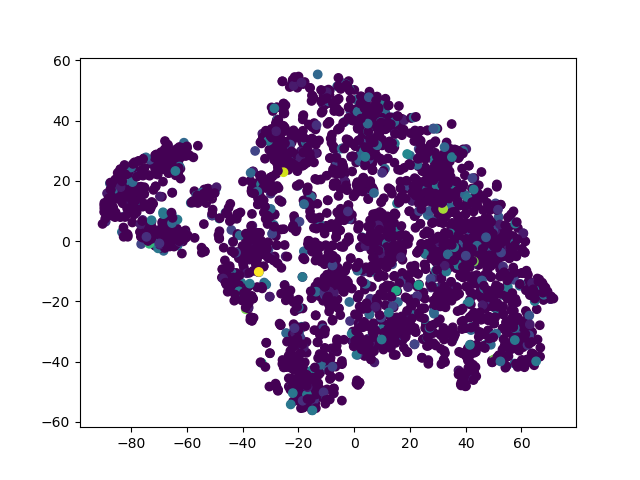

In [31]:
fig, ax = plt.subplots(1,1)
ax.cla()
ax.scatter(embed[:,0], embed[:,1], c = labels[:embed.shape[0]])